# Automatic Short Answer Grading

Calificación de una base de preguntas dataset de semeval'13


In [13]:
# Libraries
import random
import sys
import xml.etree.ElementTree as ET
#import sswe
import pandas as pd
import numpy as np
import keras
import theano
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from scipy.spatial import distance
from sklearn.metrics import accuracy_score


# Text
import gensim, logging
from nltk.tokenize import word_tokenize
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import f1_score as f1
from sklearn import cross_validation
import re
from nltk.util import ngrams
from collections import *
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from gensim.models import Doc2Vec
from gensim.models.keyedvectors import KeyedVectors# Ubuntu@Wolf



# Clasifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.linear_model import SGDClassifier


# LSTM 
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing import sequence

# xml reader
import glob

https://docs.continuum.io/anaconda/license-installation#nix-license

In [4]:
path_prep_files = 'Training/' # 2-way scientist dataset (trainning)
all_files =  glob.glob(path_prep_files+'*.xml')
print (len(all_files))
#(all_files)
#token_arr = []
#path = 'Training/'

135


In [3]:
#tree = ET.parse('Training/LF-inv1-39.xml')
#root = tree.getroot()
#question=root[0].text
#grade_st=[branch.attrib["accuracy"] for branch in root[2]]
#answers_st=[branch.text for branch in root[2]]
#answers_ref=[branch.text for branch in root[1]]### If there are more of 1 reference answer it will give an array of an answers. Make sure you integrate it before processing

In [15]:
# Word2vec
#_fname = "/home/aecarrillor/ASAG/GoogleNews-vectors-negative300.bin"# Servidor Lisi Unal
#w2vModel = Doc2Vec.load_word2vec_format(_fname, binary=True)# Servidor Lisi Unal
_fname = "/home/yagwar/data/GoogleNews-vectors-negative300.bin"# Ubuntu@Wolf
w2vModel = KeyedVectors.load_word2vec_format(_fname, binary=True)# Ubuntu@Wolf

## Medidas de desempeño

### Visualizaciones
- http://scikit-learn.org/stable/modules/model_evaluation.html
- Curva ROC
- Matriz de confusión.


### Scikit-learn basics

- Proporción de aciertos (score)
- F1 measure

### Semeval'13 Task 7
- 



# Approach 1 
### Combinar respuesta, con respuesta de referencia y pregunta en un solovector de embeddings. Luego correr los clasificadores (evaluar desempeño...)

In [16]:
# crear array con id de pregunta, textos combinados y calificación.

id_question=[]# Identificador de la pregunta (etiqueta de clase).
calif=[]# Marca de criterio.
quest=[]#Pregunta.
ref_answer=[]#Respuesta de referencia.
stud_answ=[]#Respuesta de estudiante.
#text_data=[]#pregunta + resp refer + resp est.
#txdt_Pr_REst=[]#Pregunta + Resp Estudiante.
#txdt_RRef_REst=[]#Pregunta + Resp Estudiante.

for doc in all_files:
    tree = ET.parse(doc)
    root = tree.getroot()
    question=root[0].text
    grade_st=[branch.attrib["accuracy"] for branch in root[2]]
    answers_st=[branch.text for branch in root[2]]
    answers_ref=[branch.text for branch in root[1]]# If there are more of 1 reference answer it will give an array of an answers. Make sure you integrate it before processing
    for ith_ans,st_answ in enumerate(answers_st):
        quest.append(question)
        ref_answer.append(answers_ref[0])
        stud_answ.append(st_answ)
        # Unir pregunta + respuesta de referencia + Respuesta estudiante.
        #unif_str=''.join([question," ", answers_ref[0]," ", st_answ])
        #text_data.append(unif_str)
        # unir pregunta + respuesta estudiante.
        #unif_str_Pr_REst=''.join([question," ", st_answ])
        #txdt_Pr_REst.append(unif_str_Pr_REst)
        # Unir Respuesta de referencia + Respuesta estudiante.
        #unif_str_RRef_REst=''.join([answers_ref[0]," ", st_answ])
        #txdt_RRef_REst.append(unif_str_RRef_REst)
        
        id_question.append(root.attrib["id"])
        st_ans_calif=str(grade_st[ith_ans])
        calif.extend([1 if st_ans_calif=="correct" else 0])
        
    #print (doc, "respuestas referencia= ",len(root[1]))#[0].text)

mean= 13.9454618636
stdev= 8.72338513491
max= 128


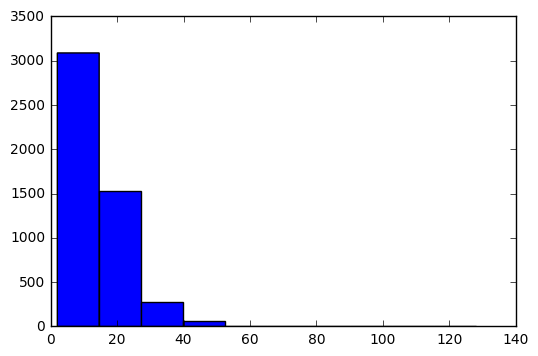

In [17]:
ext_resp=[len(nltk.word_tokenize(StAns)) for StAns in stud_answ]
plt.hist(ext_resp)
print ("mean=",np.mean(ext_resp))
print ("stdev=",np.std(ext_resp))
print ("max=",max(ext_resp))

mean= 50.7409941638
stdev= 33.4756534216
max= 213


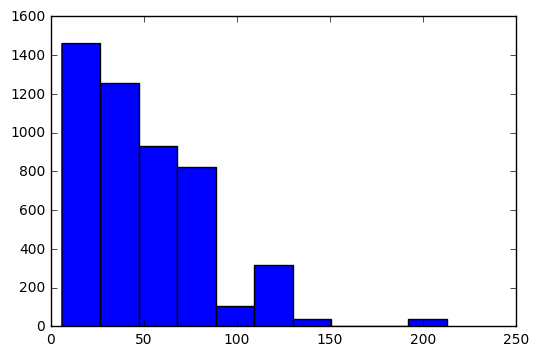

In [18]:
ext_qt=[len(nltk.word_tokenize(qt)) for qt in quest]
plt.hist(ext_qt)
print ("mean=",np.mean(ext_qt))
print ("stdev=",np.std(ext_qt))
print ("max=",max(ext_qt))

mean= 19.6168243107
stdev= 10.6489231378
max= 57


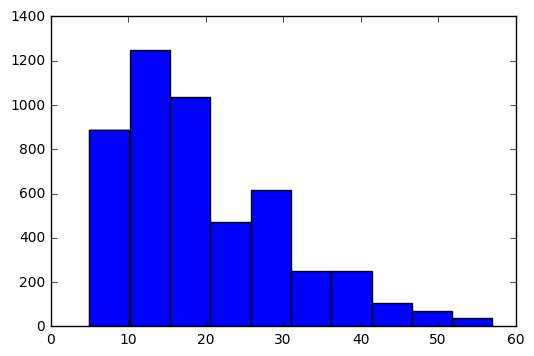

In [19]:
ext_refans=[len(nltk.word_tokenize(RefAns)) for RefAns in ref_answer]
plt.hist(ext_refans)
print ("mean=",np.mean(ext_refans))
print ("stdev=",np.std(ext_refans))
print ("max=",max(ext_refans))

In [20]:
sample=[random.randint(0,len(id_question)) for i in xrange(1)]
[print (ith,"****||Question id: ",id_question[ith],
        "|| Question: ", quest[ith],
        "|| Reference Answer: ",ref_answer[ith],
        "|| Student Answer: ",stud_answ[ith],
        "|| Accuracy: ",calif[ith]) for ith in sample]

919 ****||Question id:  II_20b || Question:  When Sarah did the chromatography test, she saw that one black ink stayed black and didn't separate. She discovered that she had used a permanent marker. She wondered what would happen if she used a different liquid. She wrote in her science notebook, What if I used vinegar in place of the water? Can I get the pigments in permanent ink to separate? How will Sarah know if vinegar separated the permanent ink? || Reference Answer:  Seeing multiple colors would show that vinegar can separate the permanent ink. || Student Answer:  Because it will start to do like a mountain. || Accuracy:  0


[None]

### 1.1 w2vec preg+ref_ans+st_ans
Crear función para transformar los textos a los embeddings de w2vec.
- Tokenizar.
- to lower.


In [21]:
def w2vec_txts(txts):
    return np.array([(sum([w2vModel[word.lower()] for word in nltk.word_tokenize(StAns) if word.lower() in w2vModel ])/
                       len([w2vModel[word.lower()] for word in nltk.word_tokenize(StAns) if word.lower() in w2vModel])) 
                       for StAns in txts])

def w2vec_txts_unorm(txts):
    return np.array([(sum([w2vModel[word.lower()] for word in nltk.word_tokenize(StAns) if word.lower() in w2vModel ]))
                       for StAns in txts])

In [33]:
w2v_questions=w2vec_txts(quest)
w2v_RefAns=w2vec_txts(ref_answer)
w2v_StudAns=w2vec_txts(stud_answ)

# w2v_questions=w2vec_txts_unorm(quest)
# w2v_RefAns=w2vec_txts_unorm(ref_answer)
# w2v_StudAns=w2vec_txts_unorm(stud_answ)

In [34]:
Preg_RefAns_StAns=[]
for i in xrange(len(w2v_questions)):
    vec_900=[]
    vec_900.extend(w2v_questions[i])
    vec_900.extend(w2v_RefAns[i])
    vec_900.extend(w2v_StudAns[i])
    Preg_RefAns_StAns.append(vec_900)

In [35]:
print (" Dimensiones:",len (Preg_RefAns_StAns[0])," Respuestas:",len (Preg_RefAns_StAns))

 Dimensiones: 900  Respuestas: 4969


3940 1


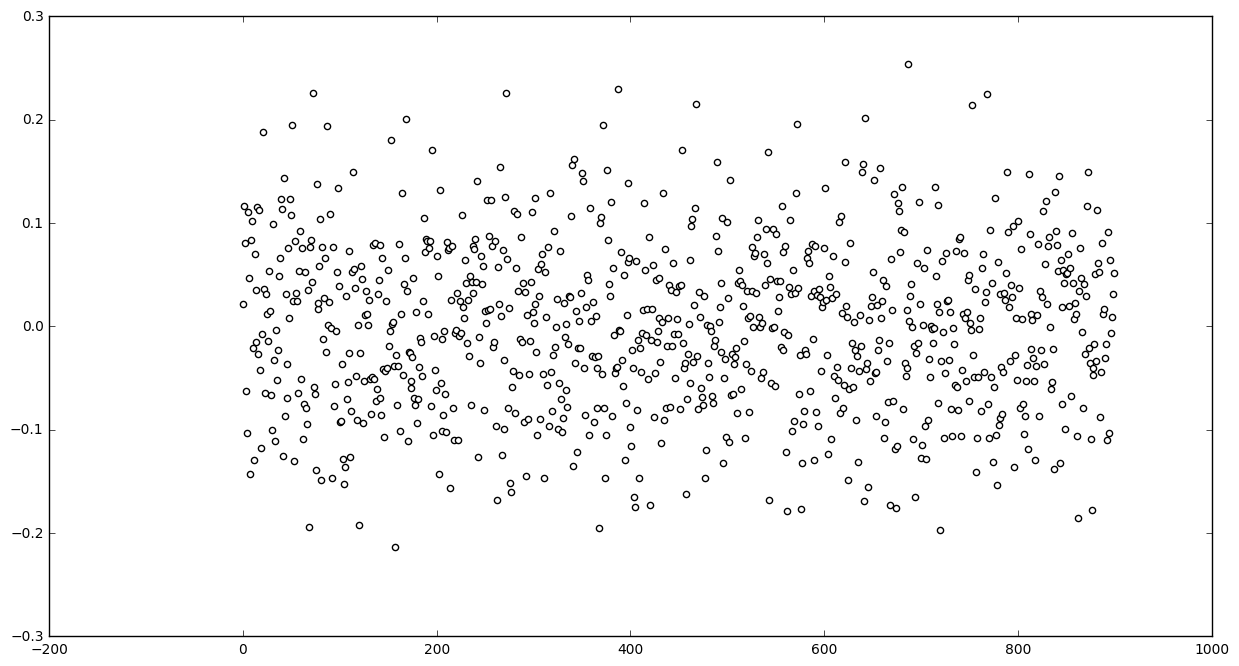

In [36]:
plt.figure(figsize=(15,8))
sample_quest=random.randint(0,len(id_question))
print (sample_quest, calif[sample_quest])
plt.scatter(range(len(Preg_RefAns_StAns[sample_quest])),Preg_RefAns_StAns[sample_quest], c=str(calif[sample_quest]))

In [37]:
# #split data
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v= train_test_split(Preg_RefAns_StAns,calif, test_size=0.25, random_state=42)

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = SGDClassifier(loss="hinge", penalty="l2", n_iter=1500)
#svr = svm.SVC(kernel='rbf')
#svp = svm.SVC(kernel='poly')
rfc = RandomForestClassifier(n_estimators=100)

clf_scores_w2v=[]
f1_eval_w2v=[]

clasifs_w2v=[]

for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'SVM -Lineal'),
 #                 (svr, 'SVM -Gauss Kernel'),
 #                 (svp, 'SVM -Poly Kernel'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train_w2v, y_train_w2v)
    yhat = clf.predict(X_test_w2v)
    clf_scores_w2v.append(clf.score(X_test_w2v,y_test_w2v))
    f1_eval_w2v.append(f1(y_test_w2v, yhat, average='weighted'))####### F1 weighted Average parameter
    clasifs_w2v.append(name)

results_w2v=pd.DataFrame(np.column_stack(([round(scr,4) for scr in clf_scores_w2v],[round(scr,4) for scr in f1_eval_w2v])),columns=["Score","F1 test"], index=clasifs_w2v)
results_w2v

,Score,F1 test
Logistic,0.7200,0.7124
Naive Bayes,0.5937,0.5954
SVM -Lineal,0.7233,0.7203
Random Forest,0.7763,0.7716


### 1.2 preg + st_ans

In [38]:
Preg_StAns=[]
for i in xrange(len(w2v_questions)):
    vec_600=[]
    vec_600.extend(w2v_questions[i])
    vec_600.extend(w2v_StudAns[i])
    Preg_StAns.append(vec_600)

In [39]:
print (" Dimensiones:",len (Preg_StAns[0])," Respuestas:",len (Preg_StAns))

 Dimensiones: 600  Respuestas: 4969


4685 1


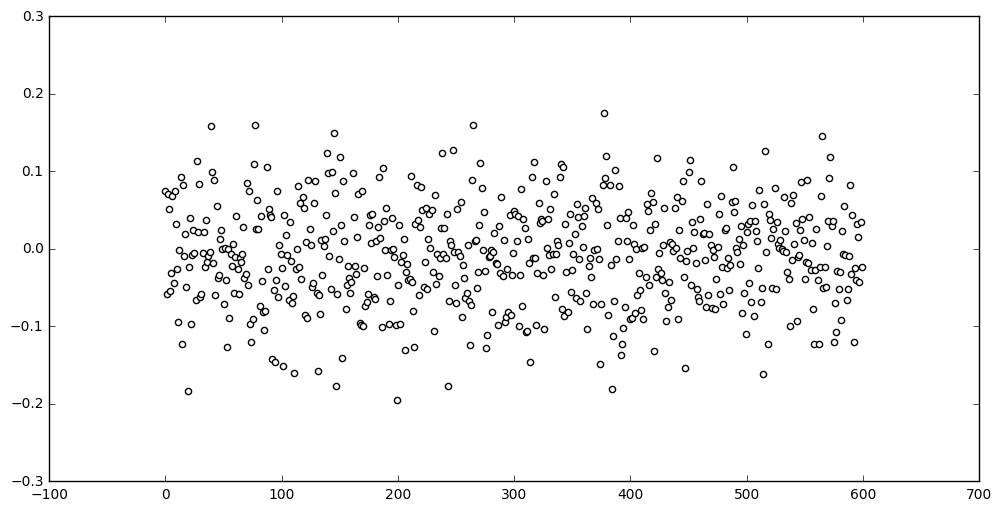

In [40]:
plt.figure(figsize=(12,6))
sample_quest=random.randint(0,len(id_question))
print (sample_quest, calif[sample_quest])
plt.scatter(range(len(Preg_StAns[sample_quest])),Preg_StAns[sample_quest], c=str(calif[sample_quest]))

In [41]:
# #split data
X_train_w2v_Pr_REst, X_test_w2v_Pr_REst, y_train_w2v_Pr_REst, y_test_w2v_Pr_REst= train_test_split(Preg_StAns,calif, test_size=0.25, random_state=42)

clf_scores_w2v_Pr_REst=[]
f1_eval_w2v_Pr_REst=[]
clasifs_w2v_Pr_REst=[]

for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'SVM -Lineal'),
#                  (svr, 'SVM -Gauss Kernel'),
#                  (svp, 'SVM -Poly Kernel'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train_w2v_Pr_REst, y_train_w2v_Pr_REst)
    yhat_Pr_REst = clf.predict(X_test_w2v_Pr_REst)
    clf_scores_w2v_Pr_REst.append(clf.score(X_test_w2v_Pr_REst,y_test_w2v_Pr_REst))
    f1_eval_w2v_Pr_REst.append(f1(y_test_w2v_Pr_REst, yhat_Pr_REst))
    clasifs_w2v_Pr_REst.append(name)

results_w2v_Pr_REst=pd.DataFrame(np.column_stack(([round(scr,4) for scr in clf_scores_w2v_Pr_REst],[round(scr,4) for scr in f1_eval_w2v_Pr_REst])),columns=["Score","F1 test"], index=clasifs_w2v)
results_w2v_Pr_REst

,Score,F1 test
Logistic,0.7168,0.5839
Naive Bayes,0.5326,0.5575
SVM -Lineal,0.7047,0.5890
Random Forest,0.7723,0.6838


# Approach 2
### Asignar la pregunta a la clase y utilizar un clasificador multiclases
- Sólo la respuesta correcta (generar nuevo dataset).
- La respuesta incorrecta va sin clase.

# Approach 3

### MDP

In [1]:
from sklearn.neural_network import MLPClassifier

In [4]:
X = [[0., 0.], [1., 1.]]
y = [0, 1]
clf = MLPClassifier(solver='lbfgs', alpha=0.1,
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X, y)                         

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [5]:
clf.predict([[2., 2.], [-1., -2.]])

array([1, 0])